## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

# Tensorflow libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#matplotlib style
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['legend.frameon'] = False


## Create binary classif dataset

In [2]:
# create datasets

data_dir_bin = "/home/titou/Documents/git/flower_image_class/data/flower_photos_binary/"
data_dir_bin = pathlib.Path(data_dir_bin)


# parameters
batch_size = 32
img_height = 180
img_width = 180

train_ds_bin = tf.keras.utils.image_dataset_from_directory(
    data_dir_bin, 
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

validation_ds_bin = tf.keras.utils.image_dataset_from_directory(
    data_dir_bin, 
    validation_split = 0.2,
    subset = "validation", 
    seed = 123, 
    image_size = (img_height, img_width),
    batch_size = batch_size
)

class_names_bin = train_ds_bin.class_names
num_classes_bin = len(class_names_bin)
print(class_names_bin)

#Preformance improvement for the IO part of the training

AUTOTUNE = tf.data.AUTOTUNE

train_ds_bin = train_ds_bin.cache().shuffle(1000, seed=123).prefetch(buffer_size=AUTOTUNE)
validation_ds_bin = validation_ds_bin.cache().prefetch(buffer_size=AUTOTUNE)


Found 1274 files belonging to 2 classes.
Using 1020 files for training.
Found 1274 files belonging to 2 classes.
Using 254 files for validation.
['daisy', 'roses']


2022-07-21 11:39:03.994956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 11:39:03.998489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 11:39:03.998634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 11:39:03.998983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Fine tune Resnet for binary classification

In [3]:
resnet50 = tf.keras.models.load_model('../data/pretrained_models/resnet50_nopooling.h5')
resnet50.trainable=False

In [8]:
# Create the new model

def exp_decay(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
    

def create_resnet(num_classes):

    model = Sequential([

        layers.Resizing(img_height, img_width),
        layers.Rescaling(1./255),
        # Data augmentation
        #layers.RandomFlip("horizontal", seed=123),
        #layers.RandomRotation(0.05, seed=123),
        #layers.GaussianNoise(0.1, seed=123),

        resnet50,
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dropout(0.2, seed=123),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])


    opt=tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

    
def train_lrscheduler(model, epochs, train_data, val_data, scheduler):
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history = model.fit(train_data, validation_data = val_data, epochs = epochs, callbacks=[callback])
    return history


def plot_acc_loss(history, epochs):

    epochs_range = range(epochs)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, label = 'Validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend()

    plt.show()
  

Epoch 1/10
32/32 [==============================] - 4s 66ms/step - loss: 1.1164 - accuracy: 0.9157 - val_loss: 0.8447 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 2s 52ms/step - loss: 0.3101 - accuracy: 0.9588 - val_loss: 0.5063 - val_accuracy: 0.9488 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 2s 52ms/step - loss: 0.0465 - accuracy: 0.9882 - val_loss: 0.4804 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 52ms/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 0.6863 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 2s 53ms/step - loss: 0.0055 - accuracy: 0.9971 - val_loss: 0.6527 - val_accuracy: 0.9449 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 52ms/step - loss: 0.0278 - accuracy: 0.9931 - val_loss: 0.8613 - val_accuracy: 0.9134 - lr: 0.0010
Epoch 7/10
32/32 [==============================] - 2s 52ms/step - loss: 0.0

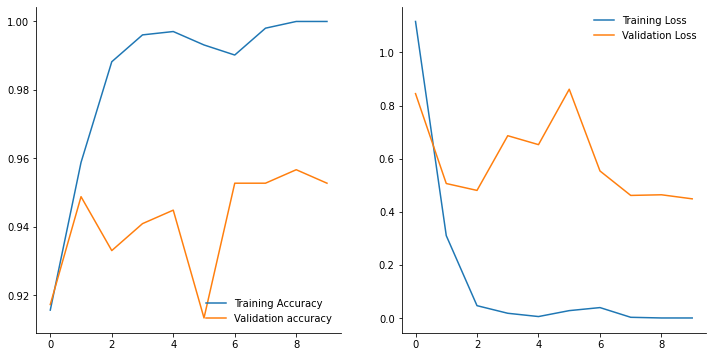

In [9]:
resnet = create_resnet(num_classes_bin)
epochs = 10
resnet_history = train_lrscheduler(resnet, epochs, train_ds_bin, validation_ds_bin, exp_decay)
plot_acc_loss(resnet_history, epochs)

